In [1]:
%cd ..
import warnings

warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)
import os
import torch
from tqdm import tqdm
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from evaluation.utils.finetune import load_model, extract_class_tokens
from evaluation.utils.classification import ImageTransform, AggregateClassTokens
from evaluation.extended_datasets.deeprdt_lung import get_dataloaders

/mnt/hydra/ubs/shared/projects/outcomes/DeepRDT/radio-foundation


In [2]:
load_dotenv()
project_path = os.getenv("PROJECTPATH")
data_path = os.getenv("DATAPATH")

In [3]:
path_to_run = "runs/base_103x4x5"
checkpoint_name = "training_69999"
device = torch.device("cuda:0")

feature_model, config = load_model(path_to_run, checkpoint_name, device)
print("Loaded model")

Loaded model


In [4]:
full_image_size = config.student.full_image_size
patch_size = config.student.patch_size
data_mean = -573.8
data_std = 461.3
channels = 4

print("Full image size:", full_image_size)

Full image size: 504


In [5]:
print("Num cpus:", os.cpu_count())

Num cpus: 128


In [6]:
img_processor = ImageTransform(full_image_size, data_mean, data_std)

dataset_kwargs = {
    "root_path": os.path.join(data_path, "dicoms"),
    "metadata_path": os.path.join(data_path, "dicoms/DeepRDT-lung/metadata_lung_oldPat.csv"),
    "transform": img_processor,
    "max_workers": 4,
}

dataloaders = get_dataloaders(dataset_kwargs, channels=4, train_val_split=0.80)
print(dataloaders.keys())

dict_keys(['train_positives', 'val_positives', 'train_negatives', 'val_negatives'])


torch.Size([27, 4, 504, 504])
embed_dim: 768
tensor(21.0988)


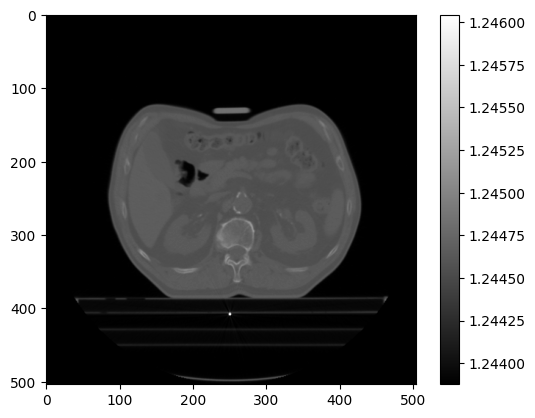

In [7]:
def get_embed_dim(test_image):
    unit_batch = test_image.view(1, channels, full_image_size, full_image_size)
    with torch.no_grad():
        outputs = feature_model(unit_batch.to(device))
    _, _, embed_dim = outputs[0][0].shape
    return embed_dim
def test_loader_and_model():
    images, labels = next(iter(dataloaders["train_positives"]))
    embed_dim = get_embed_dim(images[0])
    print(images.shape)
    print("embed_dim:", embed_dim)
    print(torch.sum(images[0]-images[1]))
    #images = images * 461.3 - 573.8
    plt.imshow(images[2][0],cmap="gray")
    plt.colorbar()
    plt.show()
test_loader_and_model()

In [8]:
embed_dim = 768
EMBED_DIM = embed_dim * 4
PATCH_SIZE = config.student.patch_size

classifier_model = AggregateClassTokens(
    embed_dim=EMBED_DIM, hidden_dim=1024, num_labels=1
).to(device)

In [9]:
class CircularList:
    def __init__(self, data: list):
        self.data = data
        self.index = 0

    def next(self):
        value = self.data[self.index]
        self.index = (self.index + 1) % len(self.data)
        return value

    def reset(self):
        self.index = 0

    def current(self):
        return self.data[self.index]

cls_cache = {}
with torch.no_grad():
    for target_label, loader_name in [(1, "train_positives"), (0, "train_negatives"), (1, "val_positives"), (0, "val_negatives")]:
        loader_cache = []
        print("Caching", loader_name)
        dataloader = iter(dataloaders[loader_name])
        for inputs, label in tqdm(dataloader):
            assert label == target_label, "label is wrong"
            x_tokens_list = feature_model(inputs.to(device))
            class_tokens = extract_class_tokens(x_tokens_list)
            loader_cache.append(class_tokens.detach().cpu())
        cls_cache[loader_name] = CircularList(loader_cache)

print("Done caching.")


Caching train_positives



00%|██████████| 92/92 [01:02<00:00,  1.47it/s]

Caching train_negatives



00%|██████████| 160/160 [01:42<00:00,  1.56it/s]

Caching val_positives



00%|██████████| 23/23 [00:15<00:00,  1.47it/s]

Caching val_negatives


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]

Done caching.


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(predictions, labels, threshold=0.5):
    binary_predictions = [x >= threshold for x in predictions]
    
    accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    f1 = f1_score(labels, binary_predictions)
    auroc = roc_auc_score(labels, predictions)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auroc": auroc
    }

iteration: 0
accuracy: 0.6349 precision: 0.0000 recall: 0.0000 f1_score: 0.0000 auroc: 0.4171 learning rate: 1e-06

iteration: 250
accuracy: 0.6349 precision: 0.0000 recall: 0.0000 f1_score: 0.0000 auroc: 0.4171 learning rate: 1e-06

iteration: 500
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5720 learning rate: 1e-06

iteration: 750
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5753 learning rate: 1e-06

iteration: 1000
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5738 learning rate: 1e-06

iteration: 1250
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5660 learning rate: 1e-06

iteration: 1500
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5746 learning rate: 1e-06

iteration: 1750
accuracy: 0.3651 precision: 0.3651 recall: 1.0000 f1_score: 0.5349 auroc: 0.5741 learning rate: 1e-06

iteration: 2000
accuracy: 0.3651 precision: 0.3651 rec

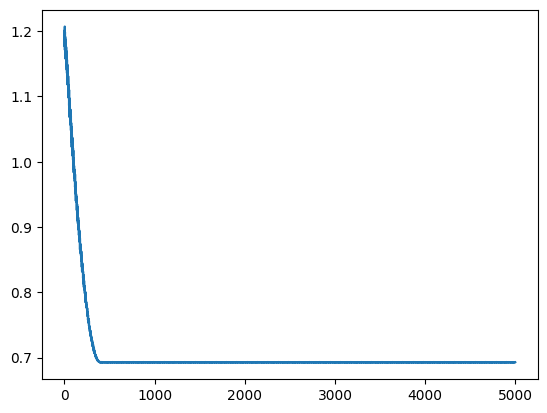

In [11]:
BATCH_SIZE = 64
EVAL_INTERVAL = 250
MAX_ITER = 5000

optimizer = torch.optim.SGD(classifier_model.parameters(), momentum=0.9, weight_decay=0, lr=0.000001)
criterion = torch.nn.BCEWithLogitsLoss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, MAX_ITER, eta_min=0.000001)

def evaluate(iteration, split="val"):
    classifier_model.eval()
    predictions = []
    labels = []

    if split=="val":
        loaders = ["val_negatives", "val_positives"]
    else:
        loaders = ["train_negatives", "train_positives"]

    for label, loader_name in enumerate(loaders):
        for class_tokens in cls_cache[loader_name].data:
            logits = classifier_model(class_tokens.to(device))
            predictions.append(logits.sigmoid().cpu().detach().flatten().numpy())
            labels.append(label)

    metrics = compute_metrics(predictions, labels)

    print("iteration:", iteration)
    for metric_name, val in metrics.items():
        print(f"{metric_name}: {val:.4f}", end=' ')
    print(f"learning rate: {optimizer.param_groups[0]['lr']}\n")

    classifier_model.train()

def train() -> int:

    classifier_model.train()
    losses = []
    grad_norms = []

    for i in range(MAX_ITER):

        if i % EVAL_INTERVAL == 0:
            evaluate(i, "train")

        optimizer.zero_grad()
        batch_loss = 0.0
        
        for batch_idx in range(BATCH_SIZE):

            if batch_idx % 2 == 0:
                class_tokens = cls_cache["train_positives"].next().to(device)
                label = 1
            else:
                class_tokens = cls_cache["train_negatives"].next().to(device)
                label = 0

            logits = classifier_model(class_tokens)
            
            loss = criterion(logits, torch.tensor([label], dtype=torch.float32).to(device)) / BATCH_SIZE
            batch_loss += loss.item()
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(classifier_model.parameters(), 1.0).item()

        optimizer.step()

        losses.append(batch_loss)
        grad_norms.append(grad_norm)

    plt.plot(losses)
    plt.show()
train()